<a href="https://colab.research.google.com/github/omullo/NLP-Playground/blob/main/4740_FA20_p1_lkn28_foo6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Language Modeling and Fake News Classification

Names: Luke Nyalala, Frank Omullo

Netids: lkn28,foo6

**After you make your own copy, please rename this notebook by clicking on it's name in the upper left corner.** It should be named: 4740_FA20_p1_netid1_netid2

Don't forget to share your newly copied notebook with your partner!

**Reminder: both of you can't work in this notebook at the same time from different computers/browser windows because of sync issues. We even suggest to close the tab with this notebook when you are not working on it so your partner doesn't get sync issues.**

## Introduction
In this project we will build an **n-gram-based language model** for fake news classification. We will also investigate a feature-based **Naive Bayes model**. The task we are faced with is to **decide whether a news article is fake or real**. While some fake articles are so absurd and nonsensical that one can clearly guess they are fake, most fake news is actually quite hard to detect. [Various studies](https://pacscenter.stanford.edu/research/program-on-democracy-and-the-internet/deception-detection-accuracy-for-fake-news-headlines-on-social-media/) have shown that most people can have an error rate up to 50% depending on the theme of the article. 

To help us approach this problem, we will use NLP techniques covered thus far to frame this as a (supervised) binary classification task, where each article will have a label $y \in \{0,1\}$, where *0 indicates a fake article* and *1 indicates a real one*. You will train and validate your two different models and then run them on a test data set with hidden $y$ labels. You will then submit the results on the test data set to Kaggle to participate in our class-wide competition!

The project is divided into six parts:
1. Dataset loading and preprocessing
2. Unsmoothed n-gram language model (LM): build the unsmoothed n-gram language model using our Fake News corpus. 
3. Smoothed n-gram language model: build a smoothed version of the model from part 2.
4. Perplexity: compute perplexity for both the unsmoothed and smoothed model
5. Putting everything together and submitting the first model to Kaggle
6. Naive Bayes: build a feature-based Naive Bayes model to perform the same classification task. Compare the LM with Naive Bayes and identify the pros and cons of each.

**Logistics:** You should work in **groups of 2 students**. Students in the same group will get the same grade. Thus, you should make sure that everyone in your group contributes to the project. 
- **Remember to form groups on BOTH CMS and Gradescope** or not all group members will receive grades. You can use the Teammate Search option on Piazza to find a partner for this project.

**Advice:** Please complete the written parts of this notebook in a clear and informative way. This is where you get to show us that you understand not only what you are doing but also why and how you are doing it. So be clear, organized and concise; avoid vagueness and excess verbiage. Spend time
doing error analysis for the models. This is how you understand the advantages and drawbacks of the systems you build. 
- It's also useful to think about how the theory of n-grams/Naive Bayes bridges with the real world application we are building. Think about what you expect from these models based on your current understanding, and then see if your expectation aligns with empirical results that you'll get. 

## General Guidelines
In this project, we provide a few code snippets or starter points in case you need them. You DO NOT need to follow the structure. 

If you think you have a better idea, go for it. You can ADD, MODIFY, or DELETE any code snippets given to you.

**Let's do this** 🚀

### Dataset

You are given a **News Corpus** on CMS, which consists of roughly the same amount of real and fake news articles.

Real news example:
```
The OpenAI technology, known as GPT-2, is designed to predict the next word given all the previous words it is shown within some text. The language-based model has been trained on a dataset of 8 million web pages.
```

Fake news example:
```
In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.
```

In the dataset folder you should find 4 files, training and validation splits for both real and fake news.

The project will proceed generally as follows in terms of code development:
1. Write code to train unsmoothed unigram and bigram language models for an arbitrary corpus
2. Implement smoothing and unknown word handling. 
3. Implement the Perplexity calculation. 
4. Using 1, 2 and 3, together with the provided training and validation sets, develop a language-model-based approach for Fake News Classification.
5. Apply your best language-model-based news classifier (from 4) to the
provided test set. Submit the results to the online Kaggle competition. 
6. Use any existing implementation of Naive Bayes (and the provided training and validation sets) to create an additional Naive Bayes fake news classifier. Apply your best NB classifier to the provided test set. Submit the results to the separate Kaggle competition (for NB classifiers). 

We will progress towards these tasks throughout this notebook.

# Part 1: Preprocessing the Dataset
In this part, you are going to do a few things:
* Connect to the google drive where the data set is stored
* Load and read files
* Preprocess the text

------
**Please upload the dataset to each partner's individual Google Drive now.** We suggest using the same folder structure within Google Drive because the notebook is shared among you, so the code to load the data would have to be changed every time if folder structures are different. One folder structure might be: Google Drive/CS 4740/Project 1/Dataset/ or whatever works for you. See our code below for an example of how we load the data from Google Drive.

## 1.1 Connect to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## 1.2 Load and read files
First, let's install [NLTK](https://www.nltk.org/), a very widely package for NLP preprocessing (and other tasks) for Python.

In [ ]:
!pip install -U nltk
!pip install contractions


Requirement already up-to-date: nltk in /usr/local/lib/python3.6/dist-packages (3.5)


Then we read and load data.

In [ ]:
import os
import io
import re
import pandas as pd
from nltk import word_tokenize, sent_tokenize, wordpunct_tokenize
from nltk.tag.perceptron import PerceptronTagger
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
import contractions
from functools import reduce
from collections import defaultdict
import nltk
import math
import csv
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

root_path = os.path.join(os.getcwd(), "drive", "My Drive/CS5740/P1") # replace based on your Google drive organization
dataset_path = os.path.join(root_path, "news_dataset") # same here

with io.open(os.path.join(dataset_path, "trueDataTrain.txt"), encoding='utf8') as real_file:
  real_news = real_file.read()
  
with io.open(os.path.join(dataset_path, "trueDataValidation.txt"), encoding='utf8') as real_file:
  real_news_validation = real_file.read()

with io.open(os.path.join(dataset_path, "fakeDataTrain.txt"), encoding='utf8') as fake_file:
  fake_news = fake_file.read()

with io.open(os.path.join(dataset_path, "fakeDataValidation.txt"), encoding='utf8') as fake_file:
  fake_news_validation = fake_file.read()



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Sanity checks for our real and fake training sets

## 1.3 Data Preprocessing & Preparation

There's a well-known parable in machine learning that 80% of the work is all about data preparation, 10% is supporting infrastructure and 10% is actual modeling. If your "raw" dataset is not preprocessed and prepared in a way to maximize its value, then your model will be more like this: https://xkcd.com/1838/. For this project, modeling is the star of the show for learning purposes, but we still want you to pay attention to the preprocessing stage.

*We've already tokenized and lowercased* the raw data for you. Here are a few extra things you might want to do:

- Think about edge cases. For example, you don't want to accidentally append a period to the last word of a sentence. 
- Watch out for apostrophes and other tricky things like quotations, they cause lots of edge cases. For example, "they're" can be all one token, or two tokens ("they", "'re") or even three tokens ("they", " ' ", "re"). 

Why did we lowercase all tokens? Because the computer will otherwise consider "The" and "the" as two separate words and this will cause problems.

Note that you may use existing
tools just for the purpose of preprocessing. 

Advice: don't get bugged down in the dozens of preprocessing packages and suggestions that you can find on Towards Data Science or Stack Overflow. Start with this [NLTK tutorial](https://lost-contact.mit.edu/afs/cs.pitt.edu/projects/nltk/docs/tutorial/introduction/nochunks.html#:~:text=The%20Natural%20Language%20Toolkit%20(NLTK,tokenization%2C%20tagging%2C%20and%20parsing.) and that should be plenty.

In [ ]:
# TODO: preprocessing

lemmatizer = WordNetLemmatizer()
tagger = PerceptronTagger()
stop_words = set(stopwords.words('english'))

def clean(s):
  s = re.sub(r'http\S*|\S*.(com|net)', '', s)
  s = s.lower()
  s = contractions.fix(s)
  return s

def lemmatize(w, tag):
  t = wordnet.NOUN
  if tag[0] == 'J':
    t = wordnet.ADJ
  if tag[0] == 'V':
    t = wordnet.VERB
  if tag[0] == 'R':
    t = wordnet.ADV
  return lemmatizer.lemmatize(w, t)

def preprocess(raw_text, start_end=False):
  """Preprocess raw_text returning list of tokens. If start_end is True,
  there are markers for start and end of sentences in the token list"""
  def passes_filter(w):
    # if (not w.isalpha()):
    #   return False 
    return True
    
  token_lst = []
  for sent in sent_tokenize(raw_text):
    sentence = clean(sent)
    if start_end:
      token_lst.append('<s>')
    for word in wordpunct_tokenize(sentence):
      if passes_filter(word):
        token_lst.append(word.lower())
    if start_end:
      token_lst.append('</s>')
  return token_lst


tokenized_real_news_training = preprocess(real_news, start_end=True)
tokenized_fake_news_training = preprocess(fake_news, start_end=True)
tokenized_real_news_validation = preprocess(real_news_validation, start_end=True)
tokenized_fake_news_validation = preprocess(fake_news_validation, start_end=True)


**Q1.1: Show some observations or statistics from the dataset** (should be quantitative – i.e. most frequent words, most frequent bigram, etc.)

Your answer:

real_train size  7155207
fake_train size  8494604
real_val size  2034517
fake_val size  2371609


Most frequent unigrams
('the', 379090)
(',', 340690)
('.', 321819)
('<s>', 232437)
('</s>', 232437)
('to', 202693)
('of', 165620)
('and', 158484)
('a', 148661)
('in', 119594)


Least frequent unigrams
('trifled', 1)
('snoke', 1)
('lummis', 1)
('steampunk', 1)
('cogs', 1)
('cheneys', 1)
('indio', 1)
('berniechella', 1)
('ozomatli', 1)
('summey', 1)


Most frequent bigrams
(('</s>', '<s>'), 232436)
(('.', '</s>'), 205725)
(('of', 'the'), 37609)
(('in', 'the'), 27664)
((',', 'and'), 26336)
((',', 'the'), 20365)
(('to', 'the'), 19210)
(('<s>', 'the'), 19118)
(('?', '</s>'), 14370)
(('on', 'the'), 13055)


Word length count


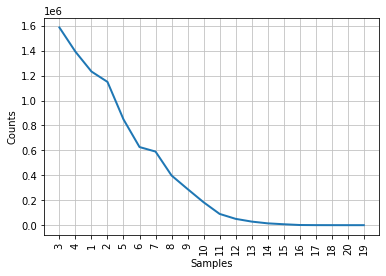

In [ ]:
# TODO: observations/statistics
num_tokens_train_real = len(tokenized_real_news_training)
num_tokens_train_fake = len(tokenized_fake_news_training)
num_tokens_val_real = len(tokenized_real_news_validation)
num_tokens_val_fake = len(tokenized_fake_news_validation)

print('real_train size ', num_tokens_train_real)
print('fake_train size ', num_tokens_train_fake)
print('real_val size ', num_tokens_val_real)
print('fake_val size ', num_tokens_val_fake)
print('\n')

fdist_counts = nltk.FreqDist(tokenized_fake_news_training)
print('Most frequent unigrams')
print(*fdist_counts.most_common(10), sep='\n')
print('\n')

least_counts = nltk.FreqDist(dict(fdist_counts.most_common()[-200:]))
print('Least frequent unigrams')
print(*least_counts.most_common(10), sep='\n')
print('\n')

fdist_bigrams = nltk.FreqDist(nltk.bigrams(tokenized_fake_news_training))
print('Most frequent bigrams')
print(*fdist_bigrams.most_common(10), sep='\n')
print('\n')

fdist_len = nltk.FreqDist([len(w) for w in tokenized_fake_news_training])
#print(*fdist_len.most_common(20), sep='\n')
print('Word length count')
nltk.FreqDist(dict(fdist_len.most_common(20))).plot()
print('\n')




**Please answer the following question**:

**Q1.2: What did you do in your preprocessing part?**



Your answer:

Reference: https://medium.com/analytics-vidhya/text-preprocessing-for-nlp-natural-language-processing-beginners-to-master-fd82dfecf95

- We removed urls from text since this is just noise and doesn't give clues to whether a news articlemis fake or real
- We also expanded contractions so that similar words aren't treated as different
- We also split words joined by separators into distinct words so that they can match with the individual words
- We tried removing punctuations and digits but model performed worse
- We also tried position tagging before lemmatization so that lemmatization is more accurate and words with similar lemma are matched but model performed worse
- We also tried removing stop words but the models performed worse so we left it out


# Part 2: Compute Unsmoothed Language Models.

To start, you will write a program that computes unsmoothed unigram and bigram probabilities. You should consider real and fake news as separate corpora and
generate a separate language model for each set of news.
We have already loaded the data and (partially) preprocessed it and you probably did some of your own preprocessing. 

Note that you were allowed to use existing
tools for the purpose of preprocessing, but you must write the code for gathering n-gram counts and computing n-gram probabilities yourself. 

For example, consider the
simple corpus consisting of the sole sentence:


> the students liked the assignment

Part of what your program would compute for a unigram and bigram model, for example,
would be the following:


> $P("the") = 0.4; P("liked") = 0.2; P("the"|"liked") = 1.0; P("students"|"the") = 0.5$

Remember to add a symbol to mark the beginning of sentence. See Sept. 7th lecture, p25-28 for an example.




**Advice**: jupyter notebooks (including colab) can be a double-edged sword. It's amazing and liberating to just start writing code and run it by simply running a cell. However, it gets messy very quickly. So, once you're done prototyping, we highly recommend using functions (classes may be unnecessary but go for it if you want) to make things cleaner and easier to debug.

## 2.1 Unsmoothed Uni-gram Model.

In this part of the project, you are trying to compute the probabilities for a unigram model. You might want to take in a list of words, and return the probabilities for each
occurence. Think of an efficient data structure to use here given what ratio of reads and puts you expect.

Please look at the example above and consider how we get the probabilities.

Below is a starter point you can go from, but you DO NOT need to stick it. Feel free to use your own design.

In [ ]:
"""
Reference code for start. You do not need to follow this.
Function [unsmoothed_unigram] computes the probabilities for a unigram model
lst: a list of words in a sentence
Return: [data structure of your choice] that stores the result
"""

def unigram_counts(lst):
  # TODO
  dict_of_words = {}
  l = len(lst)
  for word in lst:
    if word in dict_of_words:
      dict_of_words[word] += 1
    else:
      dict_of_words[word] = 1
  return (dict_of_words, l)
    


## 2.2 Unsmoothed Bi-gram Model.

In this part of the project, you are trying to compute the probabilities for a bigram model. You can approach this with similar methods as above.

Remember the definition:
$p(w_n\mid w_{n-1})=\frac{C(w_{n-1}w_n)}{C(w_{n-1})}$ this means you might want to store two things (count of $w_{n-1}$ and count of $w_{n-1}w_n$).

In [ ]:
# TODO: Add code for bigram probability calculation. 


def bigram_counts(lst):
  bigram_dict = {}
  for i in range(len(lst)-1):
    word1, word2 = lst[i], lst[i+1]
    bigram = (word1, word2)
    if bigram in bigram_dict:
      bigram_dict[bigram] += 1
    else:
      bigram_dict[bigram] = 1
  return bigram_dict

**Please answer the following question**:

**Q2: What data structure are you using to store probabilities for unigrams and bigrams? Why did you select this data structure?**

Your answer:

A dictionary because it offers constant time lookups

# Part 3: Smoothed Language Model
In this part, you will need to implement **at least one** smoothing method and **at least one** method to handle unknown words in the test data. You can choose any method(s) that you want for each. You should make clear
**what method(s)** were selected and **why**, providing a description for any non-standard approach (e.g., an approach that was not covered in class or in the readings). 

You should use the
provided validation sets to experiment with different smoothing/unknown word handling
methods if you wish to see which one is more effective for this task. (We will cover this in Part 4).

## 3.1 Unknown Words Handling

**Please answer the following questions:**

**Q3.1: How are you going to handle unknown words? What parameters might be needed? Do you need a method to determine the value?**

Your answer:

We set words occuring less than k times in the training set to unk. We determined good value for k by testing against the validation set


In [ ]:
def words_lt_k_counts(lst, k):
  """Returns words in lst whose counts are at least k"""
  fdist_counts = nltk.FreqDist(lst)
  filtered = set(filter(lambda elt: fdist_counts[elt] < k, fdist_counts.keys()))
  return filtered


In [ ]:
# TODO: Add your unknown word handling code 
def replace(lst, k):
  to_replace = words_lt_k_counts(lst,k)
  return list(map(lambda w: 'unk' if w in to_replace else w, lst))


## 3.2 Smoothing

In this part of project, we are going to compute the probabilities for unigram and bigram models after smoothing.
There are several smoothing methods you can start with:
* add-k
* Kneser-Ney
* Good-Turing
* ...

You need to compute for both unigram and bigram models.

Below is a starter point using add-k smoothing. As always, you DO NOT need to follow it; you DO NOT need to use add-k smoothing if you do not want to. You can pick ANY smoothing method you want.

In [ ]:
"""
Reference code for add-k smoothing on unigram model.
dic: a dictionary of your unigrams. key: words, val: occurence
k: parameter k for smoothing
Return: a dictionary of results after smoothing
"""

#We ended up not using the function below. Instead, we do smoothing at the same 
#time we are calculating probabilities because it was efficient that way
def add_k_unigram(dic, k):
  # TODO
  for word in dic.keys():
    dic[key] += k


In [ ]:
"""
Reference code for add-k smoothing on bigram model.
uni_dic: a dictionary of your unigrams.
bi_dic: a dictionary of your bigrams.
k: parameter k for smoothing
Return: a dictionary of results after smoothing
"""

#We ended up not using the function below. Instead, we do smoothing at the same 
#time we are calculating probabilities because it was efficient that way
def add_k_bigram(uni_dic, bi_dic, k):
  # TODO
  for bigram in bi_dic.keys():
    bi_dic[bigram] += k
    word1, word2 = bigram


**Please answer the following question:**

**Q3.2: Which smoothing method did you choose? Are there any parameters, if so how are you planning to pick the value? If you choose to implement more than 1 method (not a requirement), please state each of them. Providing a description for any non-standard approach, e.g., an approach that was not covered in class or in the readings**

Your answer:

We used add-k smoothing. We tried different values of k between 0 and 1 and set the value that gave better results on the validation set

# Part 4: Perplexity
At this point, we have developed several language models: unigram vs bigram, unsmoothed vs smoothed. We now want to compare all the models. 

Implement code to compute the perplexity of a **“development set.”** (“Development set”
is just another way to refer to the validation set—part of a dataset that is distinct from
the training portion and the test portion.) Compute and report the perplexity of each
of the language models (one trained on true news and fake news) on
the development corpora. Compute perplexity as follows:
\begin{align*}
PP &= \left(\prod_i^N\frac{1}{P\left(W_i\mid W_{i-1}, ...W_{i-n+1}\right)}\right)^{\frac{1}{N}}\\
&=\exp \frac{1}{N}\sum_{i}^N-\log P\left(W_i\mid W_{i-1}, ...W_{i-n+1}\right)
\end{align*}
where $N$ is the total number of tokens in the test corpus and $P\left(W_i\mid W_{i-1}, ...W_{i-n+1}\right)$
is the n-gram probability of your model. Under the second definition above, perplexity
is a function of the average (per-word) log probability: use this to avoid numerical
computation errors.

Please complete the following tasks and report what you have observed. Remember, lower perplexity means better model.

## Task 1: Compute perplexity for smoothed unigram and smoothed bigram. 
*Note: If you choose more than one smoothing method, pick one of them to compute. If you need to try different values of parameters, you can try them out here.*


In [ ]:
# TODO: compute perplexity for one smoothing method on unigram, and one smoothing method on bigram.

def perplexity(ds, prob_func, k, model):
  """Calculates perplexity on dataset ds using probability function prob_func
     that takes model and uses  k-smoothing"""
  n = len(ds)
  log_probs = 0
  for i in range(n):
    p = prob_func(ds, i, k, model)
    log_probs += math.log(p)*-1
  return math.exp(log_probs/n)

def unigram_prob(ds, ind, k, uni_model):
  """Calculates unigram probability of ds[ind] using uni_model and k smoothing"""
  counts,num_tokens = uni_model
  word = ds[ind] 
  if word in counts:
    c = counts[word]
  else:
    c = counts['unk']
  v = len(counts)
  return (c+k)/(num_tokens + k*v)

def bigram_prob(ds, ind, k, bi_model):
  """Calculates bigram probability of ds[ind] using uni_model and k smoothing"""
  bi_counts, uni_model = bi_model
  uni_counts, num_tokens = uni_model
  if ind > 0:
    bigram = (ds[ind-1], ds[ind])
  else:
    bigram = ('<s>', ds[ind]) 
  if bigram[0] not in uni_counts:
    bigram = ('unk', bigram[1])
  if bigram[1] not in uni_counts:
    bigram = (bigram[0], 'unk')
  c = 0
  if bigram in bi_counts:
    c = bi_counts[bigram]  
  v = len(uni_counts)
  d = k*v + uni_counts[bigram[0]]
  return (c+k)/d

unk = 10  #uknown threshold

r_news_unimodel = unigram_counts(replace(tokenized_real_news_training,unk))  
f_news_unimodel = unigram_counts(replace(tokenized_fake_news_training,unk))

r_news_bigrams = bigram_counts(replace(tokenized_real_news_training,unk))
f_news_bigrams = bigram_counts(replace(tokenized_fake_news_training,unk))


In [ ]:
r_news_uni_pp = perplexity(tokenized_real_news_validation, unigram_prob, 0.05, r_news_unimodel)
r_news_bi_pp = perplexity(tokenized_real_news_validation, bigram_prob, 0.05, (r_news_bigrams, r_news_unimodel))
f_news_uni_pp = perplexity(tokenized_fake_news_validation, unigram_prob, 0.05, f_news_unimodel)
f_news_bi_pp = perplexity(tokenized_fake_news_validation, bigram_prob, 0.05, (f_news_bigrams, f_news_unimodel))


rf_news_uni_pp = perplexity(tokenized_real_news_validation, unigram_prob, 0.05, f_news_unimodel)
rf_news_bi_pp = perplexity(tokenized_real_news_validation, bigram_prob, 0.05, (f_news_bigrams, f_news_unimodel))
fr_news_uni_pp = perplexity(tokenized_fake_news_validation, unigram_prob, 0.05, r_news_unimodel)
fr_news_bi_pp = perplexity(tokenized_fake_news_validation, bigram_prob, 0.05, (r_news_bigrams, r_news_unimodel))

print('real uni pp ', round(r_news_uni_pp), round(rf_news_uni_pp))
print('real bi pp ', round(r_news_bi_pp), round(rf_news_bi_pp))
print('fake uni pp ', round(f_news_uni_pp), round(fr_news_uni_pp))
print('fake bi pp ', round(f_news_bi_pp), round(fr_news_bi_pp))

real uni pp  716 781
real bi pp  146 273
fake uni pp  795 830
fake bi pp  192 347


In [ ]:
def ngram_val_error(k):
  misclassified = 0
  total = 0
  with io.open(os.path.join(dataset_path, "fakeDataValidation.txt"), encoding='utf8') as fake_file:
    for news in fake_file:
      total += 1
      tokenized_news = preprocess(news, start_end=True)
      pred = 0
      if len(tokenized_news) > 0:  
        r_news_pp = perplexity(tokenized_news, bigram_prob, k, (r_news_bigrams, r_news_unimodel))
        f_news_pp = perplexity(tokenized_news, bigram_prob, k, (f_news_bigrams, f_news_unimodel))
        if r_news_pp < f_news_pp:
          pred = 1
      if pred != 0:
        misclassified += 1

  with io.open(os.path.join(dataset_path, "trueDataValidation.txt"), encoding='utf8') as real_file:
    for news in real_file:
      total += 1
      tokenized_news = preprocess(news, start_end=True)
      pred = 0
      if len(tokenized_news) > 0:  
        r_news_pp = perplexity(tokenized_news, bigram_prob, k, (r_news_bigrams, r_news_unimodel))
        f_news_pp = perplexity(tokenized_news, bigram_prob, k, (f_news_bigrams, f_news_unimodel))
        if r_news_pp < f_news_pp:
          pred = 1
      if pred != 1:
        misclassified += 1
  return misclassified/total  * 100

print(ngram_val_error(0.01))

1.091314031180401


**Q4.1: Why do we need to compute perplexity after smoothing?**

Your answer:

Because to determine perplexity we need to multiply probabilities, if one of them is zero, the result becomes zero. So we need to smooth first to prevent this from happening

**Q4.2: Did you choose any values for parameters?**

Your answer:

We determined optimal values for the unknown words threshold by testing against the validation set. We used a similar procedure to determine value for add-k smoothing

## Task 2: Compute perplexity for other smoothing methods (optional). 
*Note: If you only pick one smoothing method, you can omit this task. If you need to try different values of parameters, you can try them out here.*

In [ ]:
# TODO: compute perplexity for your rest of smoothing method.

**Q4.3: If your smoothing method needs to pick a parameter, what is the value of your parameter?**

Your answer:

**Q4.4: Which smoothing method is the best among your choices?**

Your answer:

# Part 5: Putting Everything Together and Submitting to Kaggle
Combining all the previous parts together, we have developed a bunch of language models. Before we proceed to the next step, let's check a few things (no need to answer):
* Did you train your model only on training set?
* Did you validate your model only on validation/development set?
* Did you determine all your parameters?

Finally, please answer:

**Q5: What is your choice of language model, and why?**

Your answer:

We chose the bigram model because it gave lower perplexity values compared to the unigram model



In [ ]:
# TODO: anything that helps you answer/check the above points.

## Part 5.1: First Model Submission to Kaggle

Now we need to apply our model to testing data. What you need to do:
* Takes the test data as input, and generates an output of your prediction based on your chosen language model
* Your output file should be ONLY your predictions
* Submit to Kaggle

You should use your trained model to predict labels for all the news in `TestData.txt`. Output your predictions to a **csv** file and submit it to kaggle. Each line should contain the id of the test news and its corresponding prediction (in total 4489 lines). In other words, your output should look like (**including the header**):
```
Id,Prediction
0,0
1,0
2,1
3,0
...
4488,1
```
Note that you should add the header `Id,Prediction` and there is no space in the output. The Id starts from 0 (not 1).

Use this kaggle [link](https://www.kaggle.com/t/a032d54898b24b4bb2f29e7165ac5fdf) to submit your output. Your team name should be the concatenation of your netids, **exactly in the same order as this notebook is named**. For example, if notebook is 4740_FA20_p1_jb123_cj456, then Kaggle group should be jb123_cj456.


In [ ]:
# TODO: Add code to generate the Kaggle output file and submit the output file to Kaggle
with io.open(os.path.join(dataset_path, "TestData.txt"), encoding='utf8') as test_file:
  with io.open(os.path.join(dataset_path, "preds_lm.csv"), 'w', newline='') as out:
    writer = csv.writer(out)
    writer.writerow(['Id', 'Prediction'])
    count = 0
    for news in test_file:
      tokenized_news = preprocess(news, start_end=True)
      pred = 0
      if len(tokenized_news) > 0:  
        r_news_pp = perplexity(tokenized_news, bigram_prob, 0.01, (r_news_bigrams, r_news_unimodel))
        f_news_pp = perplexity(tokenized_news, bigram_prob, 0.01, (f_news_bigrams, f_news_unimodel))
        if r_news_pp < f_news_pp:
          pred = 1
      writer.writerow([count, pred])
      count += 1

# Part 6: Naive Bayes

The Naive Bayes classification method is based on Bayes Rule. Suppose we have a news article *d* and its label *c* (either 0 or 1).
\begin{align*}
P(c|d)=\frac{P(d|c)P(c)}{P(d)}
\end{align*}
Likelihood: $P(d|c)$. In real/fake corpus, how likely *d* would appear.

Prior: $P(c)$. The probability of real/fake news in general.

Posterior: $P(c|d)$. Given *d*, how likely is it that it is real/fake.

Goal: $\underset{c\in \{0,1\}}{\operatorname{argmax}} P(c|d)$, which is equivalent to $\underset{c\in \{0,1\}}{\operatorname{argmax}} P(d|c)P(c)$.

The equivalence holds because $P(d)$ is the same for any $c$. Thus the denominator can be dropped.

Denote $d=\{x_1, x_2, ..., x_n\}$ where $x_i$'s are words in the news *d* (sometimes called features). Unlike n-gram language modelling, we make the multinomial Naive Bayes independence assumption here, where we assume positions of words do not matter. Formally, 
\begin{align*}
&\underset{c\in \{0,1\}}{\operatorname{argmax}} P(d|c)P(c)\\
=&\underset{c\in \{0,1\}}{\operatorname{argmax}} P(x_1, ..., x_n|c)P(c)\\
=&\underset{c\in \{0,1\}}{\operatorname{argmax}} P(x_1|c)P(x_2|c)...P(x_n|c)
\end{align*}

Now we only need to collect the occurences of each word for the classification. This is often called a **bag of words** feature. 

For instance, in the sentence `All for one and one for all .`, the bag of words feature would be `{"all": 2, "for": 2, "one": 2, "and": 1, ".": 1}`. Essentially, the bag of words feature is a dictionary which maps the word to its occurences. We can see that the order is not considered here.

Now, your goal is to implement the Multinomial Naive Bayes. You can use existing codes or Python packages, and adapt them to our news classification task.

You might find the following packages/functions useful:

* nltk.word_tokenize(), nltk.word_tokenize()
* nltk.classify.naivebayes()
* sklearn.feature_extraction.text
* sklearn.naive_bayes.MultinomialNB()

**Please answer the following question(s).**

**Q6: Comparing Multinomial Naive Bayes with the unigram language model, which one do you expect to perform better? Why?**

A: 

A multinomial naive bayes using unigram bag of words as given above is comparable to the unigram model. But multinomialmnaive bayes with better features e.g. more than one-gram will outperform unigram model

## 6.1 Implementation

In [ ]:
X_train, X_val, X_test, Y_train, Y_val = [], [], [], [], []
with io.open(os.path.join(dataset_path, "trueDataTrain.txt"), encoding='utf8') as real_file:
  for article in real_file:
    X_train.append(article)
    Y_train.append(1)

with io.open(os.path.join(dataset_path, "fakeDataTrain.txt"), encoding='utf8') as fake_file:
  for article in fake_file:
    X_train.append(article)
    Y_train.append(0)
    
with io.open(os.path.join(dataset_path, "fakeDataValidation.txt"), encoding='utf8') as fake_file:
  for article in fake_file:
    X_val.append(article)
    Y_val.append(0)

with io.open(os.path.join(dataset_path, "trueDataValidation.txt"), encoding='utf8') as real_file:
  for article in real_file:
    X_val.append(article)
    Y_val.append(1)

with io.open(os.path.join(dataset_path, "TestData.txt"), encoding='utf8') as test_file:
  for article in test_file:
    X_test.append(article)


In [ ]:
# TODO: Naive Bayes implementation 

vectorizer = CountVectorizer(ngram_range=(3,4))
X_trains = vectorizer.fit_transform(X_train)
X_vals = vectorizer.transform(X_val)
X_tests = vectorizer.transform(X_test)
transformer = TfidfTransformer()
X_trains = transformer.fit_transform(X_trains)
X_vals = transformer.transform(X_vals)
X_tests = transformer.transform(X_tests)
clf = MultinomialNB()
clf.fit(X_trains, Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
pred_val = clf.predict(X_vals)
val_error = sum(list(map(abs, pred_val-Y_val)))/len(Y_val)
print(val_error)
pred_test = clf.predict(X_tests)



0.020378619153674834


## 6.2 Putting Everything Together and Submitting to Kaggle

You should use your trained model to predict labels for all the news in `TestData.txt`. Output your predictions to a **csv** file and submit it to kaggle. The format should follow Part 6 as well.

Use this Kaggle [link](https://www.kaggle.com/t/e8e4f7ee507843d1902c168529d705c8) to submit your output.

In [ ]:
# TODO: Code for predicting the test labels and generating the output file. Then submit the output file to Kaggle
with io.open(os.path.join(dataset_path, "preds_nb.csv"), 'w', newline='') as out:
  writer = csv.writer(out)
  writer.writerow(['Id', 'Prediction'])
  count = 0
  for pred in pred_test:
    writer.writerow([count, pred])
    count += 1

# Work Distribution

**Please briefly describe how you divided the work.**

Your answer:

We worked on the project jointly, although Frank worked mostly on part 1-3 and Luke part 4-6


# Project Feedback [1 point]
It goes without saying that this is an unprecedented time. We on the course staff are trying our best to adapt our teaching, projects and everything else in the class to this new modality. We would immenselly appreciate it if you could provide us feedback (it's a super short form!!) on this project and **it's worth 1 point of your project grade**

Link to the feedback form: https://forms.gle/xfonP9rJk9Uk7zaSA 

We will use this feedback to improve both **upcoming projects** and projects for next year. 

Thank you so much!

# Submitting the Notebook

1. Go to File (upper left corner) -> Download .ipynb -> submit this downloaded file to cms
2. Run the first code block
3. Replace our placeholder for your correct Google Drive directory structure in the 2nd code block below. Run the code block
4. Put the name of this notebook into our placeholder in the 3rd code block. Run the code block
5. Then go to the folder icon on the very left panel, under the orange CO logo. Click on the folder and wait for a PDF version of your notebook to appear. Might take a few minutes.
6. Download the pdf version and submit to Gradescope

In [ ]:
%%capture
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

In [ ]:
%%capture
# the red text is a placeholder! Change it to your directory structure!
!cp 'drive/My Drive/CS5740/P1/4740_FA20_p1_lkn28_foo6.ipynb' ./ 

In [ ]:
# the red text is a placeholder! Change it to the name of this notebook!
!jupyter nbconvert --to PDF "4740_FA20_p1_lkn28_foo6.ipynb"

[NbConvertApp] Converting notebook 4740_FA20_p1_lkn28_foo6.ipynb to PDF
[NbConvertApp] Support files will be in 4740_FA20_p1_lkn28_foo6_files/
[NbConvertApp] Making directory ./4740_FA20_p1_lkn28_foo6_files
[NbConvertApp] Writing 92448 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: [u'xelatex', u'./notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: [u'bibtex', u'./notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 110523 bytes to 4740_FA20_p1_lkn28_foo6.pdf


# You are done! ✅